In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('./data/Telco_customer_churn_with_text.csv')

# Initial exploration
print("Dataset shape:", df.shape)
print("\nFeature distribution:\n", df.describe())
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (7043, 35)

Feature distribution:
         Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7043.0   7043.000000  7043.000000  7043.000000    7043.000000   
mean      1.0  93521.964646    36.282441  -119.798880      32.371149   
std       0.0   1865.794555     2.455723     2.157889      24.559481   
min       1.0  90001.000000    32.555828  -124.301372       0.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.000000    36.391777  -119.730885      29.000000   
75%       1.0  95351.000000    38.224869  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Churn Value  Churn Score         CLTV  
count      7043.000000  7043.000000  7043.000000  7043.000000  
mean         64.761692     0.265370    58.699418  4400.295755  
std          30.090047     0.441561    21.525131  1183.057152  
min          18.250000     0.000000     5.000

In [3]:
print("Churn distribution:")
print(df['Churn Label'].value_counts(normalize=True))

Churn distribution:
Churn Label
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [3]:
# data_preprocessing.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
import joblib
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DataPreparation:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.power_transformer = PowerTransformer()
        self.imputer = SimpleImputer(strategy='median')
        
    def load_data(self, file_path):
        """Load and validate the dataset."""
        try:
            df = pd.read_csv(file_path)
            
            logger.info(f"Successfully loaded dataset with shape: {df.shape}")
            return df
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            raise
            
    def validate_data(self, df):
        """Perform basic data validation checks."""
        validation_report = {
            'missing_values': df.isnull().sum().to_dict(),
            'duplicates': df.duplicated().sum(),
            'data_types': df.dtypes.to_dict()
        }
        
        # Check for invalid values in important columns
        if 'Monthly Charges' in df.columns:
            validation_report['negative_charges'] = (df['Monthly Charges'] < 0).sum()
            
        if 'Tenure Months' in df.columns:
            validation_report['invalid_tenure'] = (df['Tenure Months'] < 0).sum()
            
        logger.info("Data validation completed")
        return validation_report
    
    def engineer_basic_features(self, df):
        """Create basic derived features."""
        df = df.copy()
        # drop unecessary columns
        df = df.drop(['CustomerID',	'Count', 'Country',	'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 
                      'Longitude', 'Churn Value', 'Churn Score',	'CLTV',	'Churn Reason', 'conversation', 'customer_text'], axis=1)

        
        # Customer value features
        df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
        df['Revenue_per_Month'] = df['Total Charges'] / df['Tenure Months']
        df['Average_Monthly_Charges'] = df['Total Charges'] / df['Tenure Months']
        df['Charges_Evolution'] = df['Monthly Charges'] - df['Average_Monthly_Charges']
        
        # Service usage features
        service_columns = ['Phone Service', 'Internet Service', 'Online Security',
                          'Online Backup', 'Device Protection', 'Tech Support',
                          'Streaming TV', 'Streaming Movies']
        
        df['Total_Services'] = df[service_columns].apply(
            lambda x: x.str.count('Yes').sum() if x.dtype == 'object' else x.sum(), axis=1
        )
        
        # Customer segments
        df['Value_Segment'] = pd.qcut(df['Monthly Charges'], q=4, 
                                    labels=['Low', 'Medium', 'High', 'Premium'])
        # ... your training code ...
        bins = pd.qcut(df['Monthly Charges'], q=4, retbins=True)[1] # Get the bin edges
        joblib.dump(bins, 'quantile_bins.pkl')  # Save the bins
        
        return df
    
    def engineer_advanced_features(self, df):
        """Create more sophisticated features."""
        df = df.copy()
        
        # Contract risk score
        contract_risk = {'Month-to-month': 3, 'One year': 2, 'Two year': 1}
        df['Contract_Risk_Score'] = df['Contract'].map(contract_risk)
        
        # Payment reliability
        payment_risk = {
            'Electronic check': 3,
            'Mailed check': 2,
            'Bank transfer (automatic)': 1,
            'Credit card (automatic)': 1
        }
        df['Payment_Risk_Score'] = df['Payment Method'].map(payment_risk)
        
        # Service dependency score
        service_weights = {
            'Phone Service': 1,
            'Internet Service': 2,
            'Online Security': 0.5,
            'Online Backup': 0.5,
            'Device Protection': 0.5,
            'Tech Support': 0.5,
            'Streaming TV': 1,
            'Streaming Movies': 1
        }
        
        df['Service_Dependency_Score'] = sum(
            (df[service] == 'Yes').astype(int) * weight
            for service, weight in service_weights.items()
        )
        
        # Loyalty-adjusted value
        df['Loyalty_Adjusted_Value'] = (
            df['Monthly Charges'] * np.log1p(df['Tenure Months'])
        )
        
        return df
    
    def encode_categorical_features(self, df):
        """Encode categorical variables with proper handling."""
        df = df.copy()
        
        # Features for label encoding
        label_encode_cols = ['Gender', 'Contract', 'Payment Method']
        
        # Features for one-hot encoding
        onehot_cols = ['Internet Service', 'Value_Segment']
        
        # Label encoding
        for col in label_encode_cols:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[f'{col}_Encoded'] = self.label_encoders[col].fit_transform(df[col])
        
        # One-hot encoding
        df = pd.get_dummies(df, columns=onehot_cols, prefix=onehot_cols)
        
        return df
    
    def scale_numerical_features(self, df):
        """Scale numerical features with proper handling of skewness."""
        df = df.copy()
        
        # Basic numerical features
        basic_num_cols = ['Monthly Charges', 'Total Charges', 'Tenure Months']
        
        # Derived numerical features
        derived_num_cols = ['Revenue_per_Month', 'Average_Monthly_Charges',
                          'Charges_Evolution', 'Service_Dependency_Score',
                          'Loyalty_Adjusted_Value']
        
        all_num_cols = [col for col in basic_num_cols + derived_num_cols 
                       if col in df.columns]
        
        # Handle missing values
        df[all_num_cols] = self.imputer.fit_transform(df[all_num_cols])
        
        # Apply power transform for heavily skewed features
        df[all_num_cols] = self.power_transformer.fit_transform(df[all_num_cols])
        
        # Standard scaling
        df[all_num_cols] = self.scaler.fit_transform(df[all_num_cols])
        
        return df
    
    def prepare_data(self, file_path):
        """Complete data preparation pipeline."""
        # Load and validate
        df = self.load_data(file_path)
        validation_report = self.validate_data(df)
        
        if validation_report['duplicates'] > 0:
            logger.warning(f"Found {validation_report['duplicates']} duplicate rows")
            df = df.drop_duplicates()
        
        # Feature engineering
        df = self.engineer_basic_features(df)
        df = self.engineer_advanced_features(df)
        
        # Encoding and scaling
        df = self.encode_categorical_features(df)
        df = self.scale_numerical_features(df)
        
        logger.info("Data preparation completed successfully")
        return df, validation_report

if __name__ == "__main__":
    prep = DataPreparation()
    processed_df, validation_report = prep.prepare_data('./data/Telco_customer_churn_with_text.csv')
    processed_df.to_csv('./data/processed_telco_data.csv', index=False)

INFO:__main__:Successfully loaded dataset with shape: (7043, 35)
INFO:__main__:Data validation completed
INFO:__main__:Data preparation completed successfully


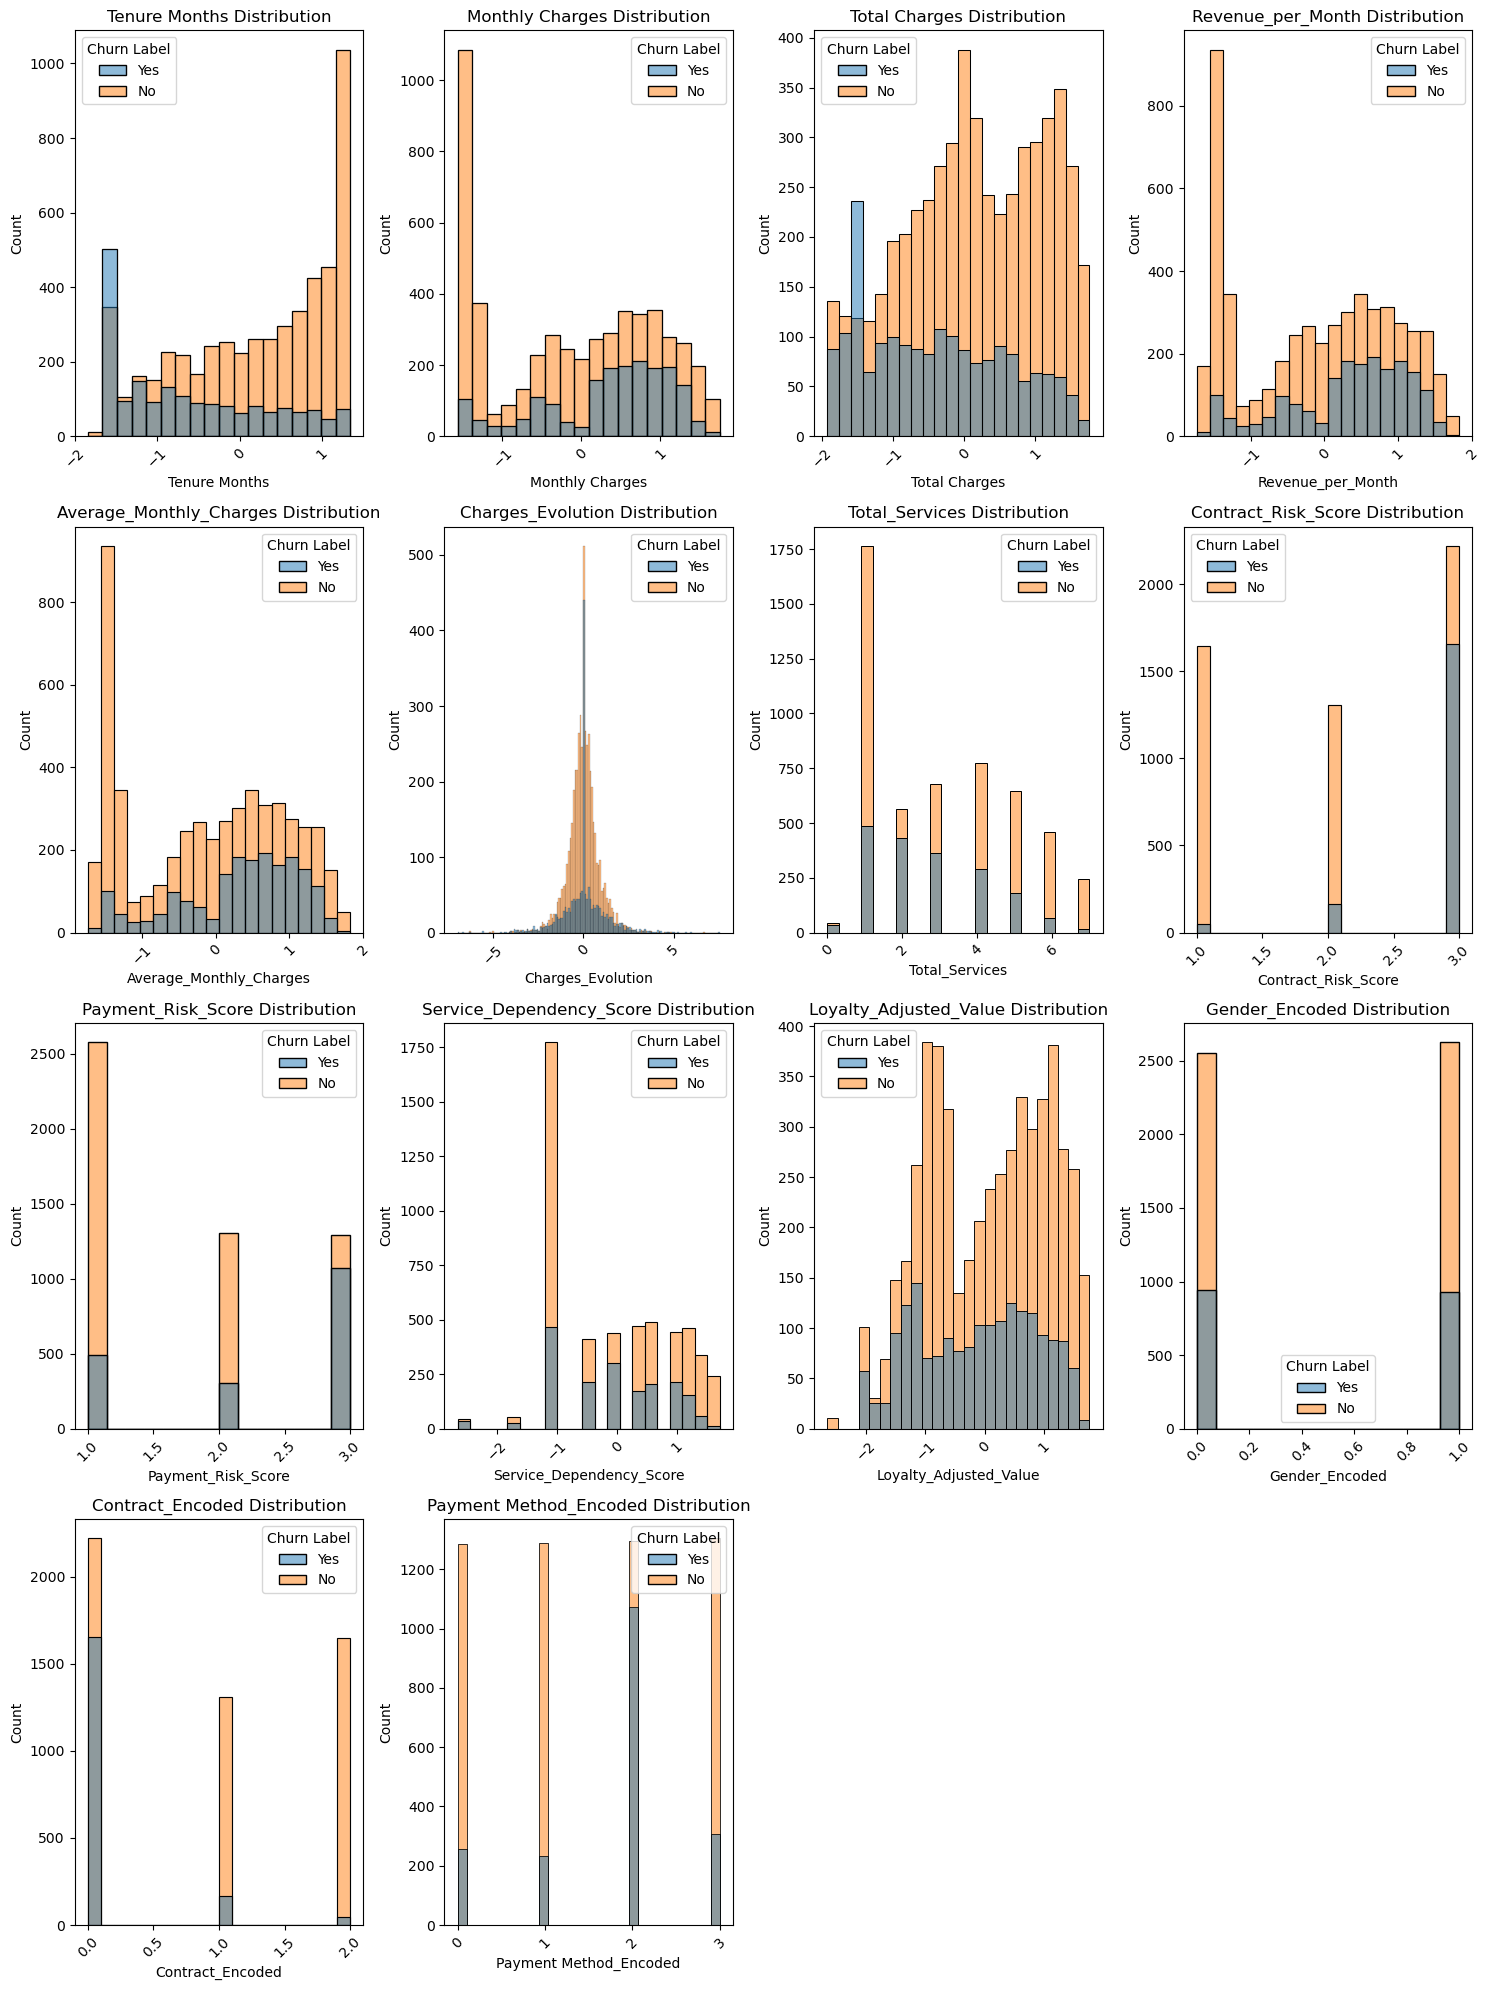

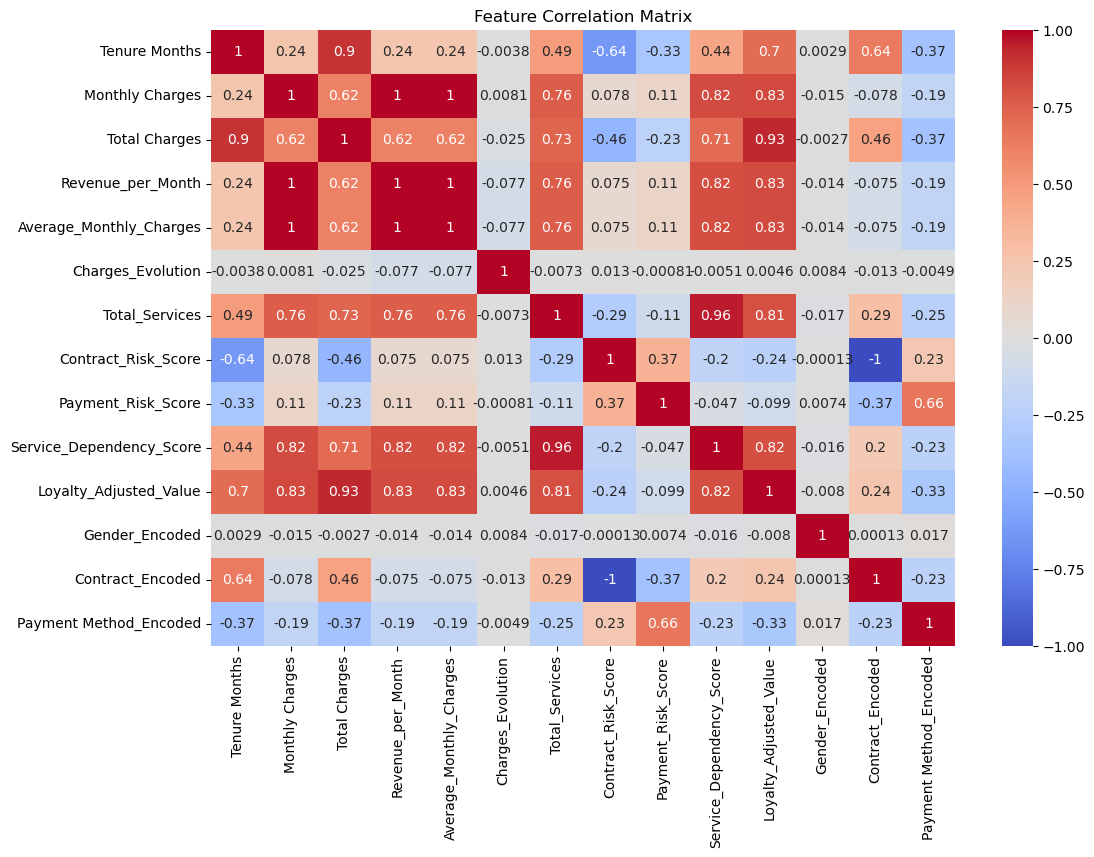

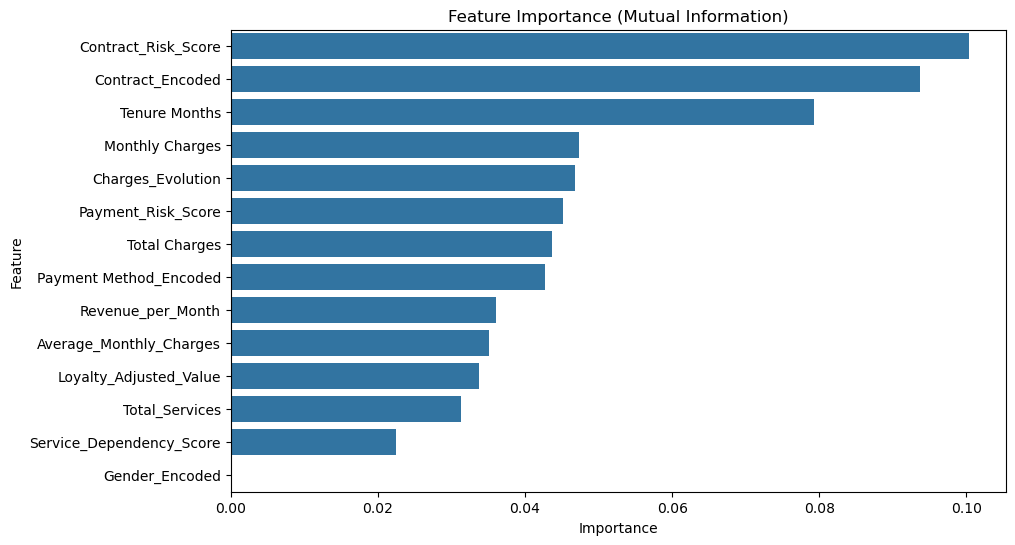

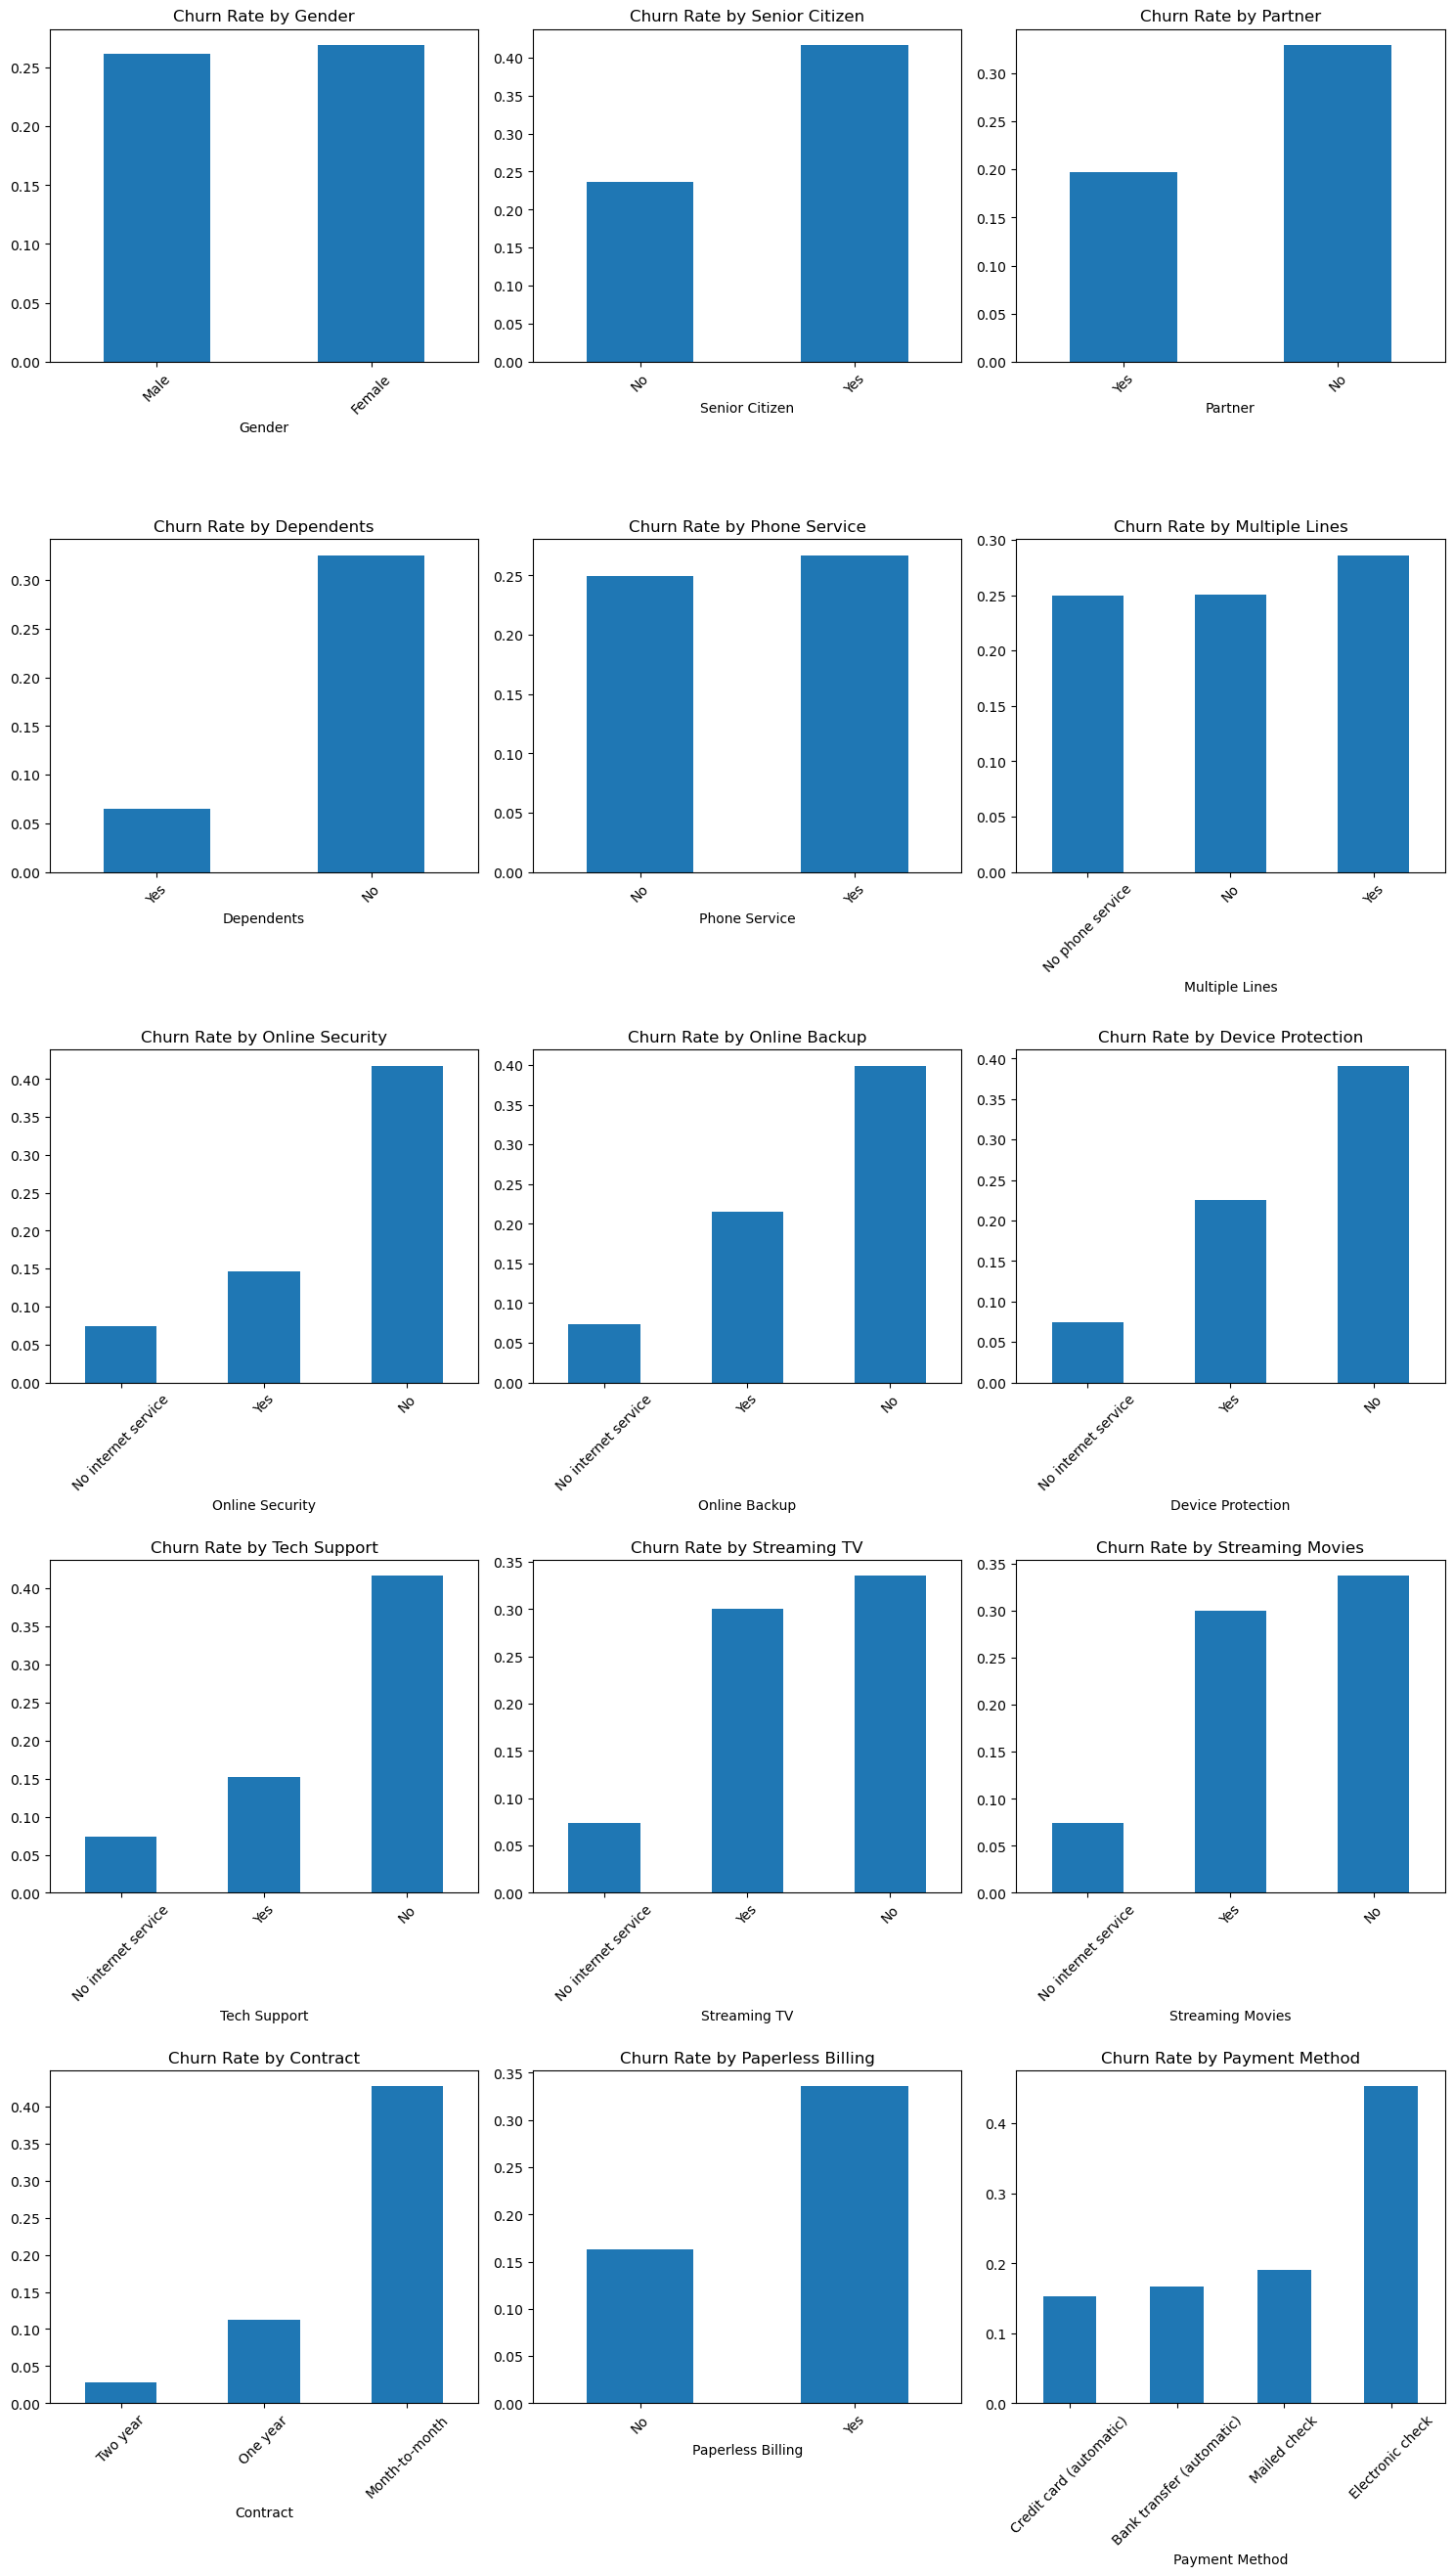

In [4]:
# feature_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import math
import os

class FeatureAnalysis:
    def __init__(self, df):
        self.df = df
        self.numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
        self.categorical_cols = df.select_dtypes(include=['object']).columns
        
    def plot_feature_distributions(self, save_path=None):
        """Plot distributions of numerical features."""
        num_features = len(self.numerical_cols)
        num_cols = 4  # Set columns to 4 for better spacing
        num_rows = math.ceil(num_features / num_cols)  # Adjust rows dynamically
        
        plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on rows
        for i, col in enumerate(self.numerical_cols, 1):
            plt.subplot(num_rows, num_cols, i)
            sns.histplot(data=self.df, x=col, hue='Churn Label', alpha=0.5)
            plt.title(f'{col} Distribution')
            plt.xticks(rotation=45)
        plt.tight_layout()
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, 'feature_distributions.png'))

        plt.show()

    def plot_correlation_matrix(self, save_path=None):
        """Plot correlation matrix of numerical features."""
        corr_matrix = self.df[self.numerical_cols].corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, 'correlation_matrix.png'))

        plt.show()
        
    def plot_feature_importance(self, target_col='Churn Label', save_path=None):
        """Calculate and plot feature importance using mutual information."""
        X = self.df[self.numerical_cols]
        y = (self.df[target_col] == 'Yes').astype(int)
        
        # Calculate mutual information scores
        mi_scores = mutual_info_classif(X, y)
        importance_df = pd.DataFrame({
            'Feature': self.numerical_cols,
            'Importance': mi_scores
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance_df, x='Importance', y='Feature')
        plt.title('Feature Importance (Mutual Information)')

        if save_path:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, 'feature_importance.png'))
        
        return importance_df
    
    def plot_categorical_analysis(self, save_path=None):
        """Analyze categorical features relationship with churn."""
        num_features = len(self.categorical_cols)
        num_cols = 3  # Set to 3 columns for a cleaner view
        num_rows = math.ceil(num_features / num_cols)  # Dynamically adjust rows

        plt.figure(figsize=(15, 5 * num_rows))
        for i, col in enumerate(self.categorical_cols, 1):
            if col != 'Churn Label':
                plt.subplot(num_rows, num_cols, i)
                churn_props = self.df.groupby(col)['Churn Label'].value_counts(normalize=True).unstack()
                if 'Yes' in churn_props.columns:
                    churn_props['Yes'].sort_values().plot(kind='bar')
                else:
                    churn_props.plot(kind='bar', stacked=True)
                plt.title(f'Churn Rate by {col}')
                plt.xticks(rotation=45)
        plt.tight_layout()
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(os.path.join(save_path, 'categorical_analysis.png'))
        plt.show()
    
    def generate_feature_report(self, save_path=None):
        """Generate a comprehensive feature analysis report."""
        report = {
            'numerical_stats': self.df[self.numerical_cols].describe(),
            'categorical_stats': {
                col: self.df[col].value_counts(normalize=True)
                for col in self.categorical_cols
            },
            'missing_values': self.df.isnull().sum(),
            'correlation_analysis': self.df[self.numerical_cols].corr()
        }
        
        if save_path:
            with open(f'{save_path}/feature_report.txt', 'w') as f:
                for section, data in report.items():
                    f.write(f'\n{section.upper()}\n{"="*50}\n')
                    f.write(str(data))
                    f.write('\n\n')
                    
        return report

if __name__ == "__main__":
    # Load processed data
    df = pd.read_csv('./data/processed_telco_data.csv')
    
    # Create analysis object
    analyzer = FeatureAnalysis(df)
    
    # Generate visualizations
    analyzer.plot_feature_distributions('outputs')
    analyzer.plot_correlation_matrix('outputs')
    analyzer.plot_feature_importance(target_col='Churn Label', save_path='outputs')
    analyzer.plot_categorical_analysis('outputs')
    
    # Generate report
    report = analyzer.generate_feature_report('outputs')


In [6]:
# feature_selection.py
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
import joblib
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class FeatureSelector:
    def __init__(self, df, target_col='Churn Label'):
        self.df = df.copy()
        self.target_col = target_col
        self.le = LabelEncoder()
        
        # Ensure only numerical columns are used
        self.numerical_cols = self.df.select_dtypes(include=['number']).columns.tolist()
        if self.target_col in self.numerical_cols:
            self.numerical_cols.remove(self.target_col)
    
    def prepare_target(self):
        """Prepare target variable for selection methods."""
        return self.le.fit_transform(self.df[self.target_col])
    
    def filter_method(self, k=10):
        """Select features using mutual information."""
        y = self.prepare_target()
        X = self.df[self.numerical_cols]
        
        # Select features
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        selector.fit(X, y)
        
        # Get selected features
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = pd.DataFrame({
            'Feature': X.columns,
            'Score': selector.scores_
        }).sort_values('Score', ascending=False)
        
        logger.info(f"Selected {len(selected_features)} features using mutual information")
        return selected_features, feature_scores
    
    def wrapper_method(self, n_features=10):
        """Select features using Recursive Feature Elimination."""
        y = self.prepare_target()
        X = self.df[self.numerical_cols]
        
        # Initialize estimator
        estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        selector = RFE(estimator=estimator, n_features_to_select=n_features)
        
        # Fit selector
        selector.fit(X, y)
        
        # Get selected features
        selected_features = X.columns[selector.support_].tolist()
        feature_ranks = pd.DataFrame({
            'Feature': X.columns,
            'Rank': selector.ranking_
        }).sort_values('Rank')
        
        logger.info(f"Selected {len(selected_features)} features using RFE")
        return selected_features, feature_ranks
    
    def boruta_selection(self):
        """Select features using Boruta algorithm."""
        y = self.prepare_target()
        X = self.df[self.numerical_cols]
        
        # Initialize Random Forest classifier
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=42)
        
        # Initialize Boruta
        boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
        
        # Fit Boruta
        boruta.fit(X.values, y)
        
        # Get selected features
        selected_features = X.columns[boruta.support_].tolist()
        feature_ranks = pd.DataFrame({
            'Feature': X.columns,
            'Boruta_Ranking': boruta.ranking_
        }).sort_values('Boruta_Ranking')
        
        logger.info(f"Selected {len(selected_features)} features using Boruta")
        return selected_features, feature_ranks

if __name__ == "__main__":
    df = pd.read_csv('./data/processed_telco_data.csv')
    selector = FeatureSelector(df)
    
    selected_kbest, kbest_scores = selector.filter_method(k=10)
    selected_rfe, rfe_ranks = selector.wrapper_method(n_features=10)
    selected_boruta, boruta_ranks = selector.boruta_selection()
    # store features
    joblib.dump(selected_boruta, "baseline_boruta_features.pkl")
    
    print("Top Features from SelectKBest:", selected_kbest)
    print("Top Features from RFE:", selected_rfe)
    print("Top Features from Boruta:", selected_boruta)


INFO:__main__:Selected 10 features using mutual information
INFO:__main__:Selected 10 features using RFE


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0


INFO:__main__:Selected 13 features using Boruta


Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1
Top Features from SelectKBest: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Average_Monthly_Charges', 'Charges_Evolution', 'Contract_Risk_Score', 'Payment_Risk_Score', 'Loyalty_Adjusted_Value', 'Contract_Encoded', 'Payment Method_Encoded']
Top Features from RFE: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Revenue_per_Month', 'Average_Monthly_Charges', 'Charges_Evolution', 'Contract_Risk_Score', 'Payment_Risk_Score', 'Loyalty_Adjusted_Value', 'Contract_Encoded']
Top Features from Boruta: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Revenue_per_Month', 'Average_Monthly_Charges', 'Charges_Evolution', 'Total_Services', 'Contract_Risk_Score', 'Payment_Risk_Score', 'Service_Dependency_Score', 'Loyalty_Adjusted_Value', 'Contract_Encoded', 'Payment Method_Encoded']


## Let's Run a baseline Model as follows:

In [7]:
# baseline_model.py
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load Data
df = pd.read_csv("./data/processed_telco_data.csv")

# Feature Selection
class FeatureSelector:
    def __init__(self, df, target_col='Churn Label'):
        self.df = df.copy()
        self.target_col = target_col
        self.le = LabelEncoder()
        
        # Ensure only numerical columns are used
        self.numerical_cols = self.df.select_dtypes(include=['number']).columns.tolist()
        if self.target_col in self.numerical_cols:
            self.numerical_cols.remove(self.target_col)
    
    def prepare_target(self):
        """Prepare target variable for selection methods."""
        return self.le.fit_transform(self.df[self.target_col])
    def boruta_selection(self):
        """Select features using Boruta algorithm."""
        y = self.prepare_target()
        X = self.df[self.numerical_cols]
        
        # Initialize Random Forest classifier
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=42)
        
        # Initialize Boruta
        boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
        
        # Fit Boruta
        boruta.fit(X.values, y)
        
        # Get selected features
        selected_features = X.columns[boruta.support_].tolist()
        feature_ranks = pd.DataFrame({
            'Feature': X.columns,
            'Boruta_Ranking': boruta.ranking_
        }).sort_values('Boruta_Ranking')
        
        logger.info(f"Selected {len(selected_features)} features using Boruta")
        return selected_features, feature_ranks

if __name__ == "__main__":
    df = df 
    selector = FeatureSelector(df)
    selected_boruta, boruta_ranks = selector.boruta_selection()
    
    # Save features
    joblib.dump(selected_boruta, "baseline_boruta_features.pkl")

    print("Top Features from Boruta:", selected_boruta)

# Prepare Data
selected_features = joblib.load('baseline_boruta_features.pkl')
X = df[selected_features]
y = df["Churn Label"].apply(lambda x: 1 if x == "Yes" else 0)  # Convert target to binary

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save Scaler
joblib.dump(scaler, "baseline_scaler.pkl")

# Define Model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Model
best_model = grid_search.best_estimator_
joblib.dump(best_model, "baseline_churn_model.pkl")

# Evaluate Model
y_pred = best_model.predict(X_test_scaled)
logger.info(f"Accuracy: {accuracy_score(y_test, y_pred)}")
logger.info(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	0


INFO:__main__:Selected 13 features using Boruta


Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	1
Top Features from Boruta: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Revenue_per_Month', 'Average_Monthly_Charges', 'Charges_Evolution', 'Total_Services', 'Contract_Risk_Score', 'Payment_Risk_Score', 'Service_Dependency_Score', 'Loyalty_Adjusted_Value', 'Contract_Encoded', 'Payment Method_Encoded']


INFO:__main__:Accuracy: 0.8026969481902059
INFO:__main__:Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



## We will now extract textual features

Run this command to generate model data

```bash
python generate_model_data.py`

```

This command will add textual features (sentiment and embeddings to the data frame)
Please be patient, the model may take sometime to generate sentiments and embeddings using hugging face. You can also generate model data (you don't have to because we already have the data in the `data` folder). You can also run the `generate_model_data.py` in this notebook as follows:

In [ ]:
import pandas as pd
from data_preparation import DataPreparation

# Load Data
prep = DataPreparation()
df = pd.read_csv("./data/Telco_customer_churn_with_text.csv")
new_df, validation_report = prep.prepare_data(df)
new_df = new_df.iloc[:, 1:]
new_df.to_csv("./data/model_data.csv")

# Alert user when the process is complete
print("Prepared model data successefully!")


## Run the model (with customer profile & textual features)

In [8]:
# model.py

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load Data
df = pd.read_csv("./data/model_data.csv")

# Feature Selection
class FeatureSelector:
    def __init__(self, df, target_col='Churn Label'):
        self.df = df.copy()
        self.target_col = target_col
        self.le = LabelEncoder()
        
        # Ensure only numerical columns are used
        self.numerical_cols = self.df.select_dtypes(include=['number']).columns.tolist()
        if self.target_col in self.numerical_cols:
            self.numerical_cols.remove(self.target_col)
    
    def prepare_target(self):
        """Prepare target variable for selection methods."""
        return self.le.fit_transform(self.df[self.target_col])
    def boruta_selection(self):
        """Select features using Boruta algorithm."""
        y = self.prepare_target()
        X = self.df[self.numerical_cols]
        
        # Initialize Random Forest classifier
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=42)
        
        # Initialize Boruta
        boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
        
        # Fit Boruta
        boruta.fit(X.values, y)
        
        # Get selected features
        selected_features = X.columns[boruta.support_].tolist()
        feature_ranks = pd.DataFrame({
            'Feature': X.columns,
            'Boruta_Ranking': boruta.ranking_
        }).sort_values('Boruta_Ranking')
        
        logger.info(f"Selected {len(selected_features)} features using Boruta")
        return selected_features, feature_ranks

if __name__ == "__main__":
    df = df 
    selector = FeatureSelector(df)
    selected_boruta, boruta_ranks = selector.boruta_selection()
    
    # Save features
    joblib.dump(selected_boruta, "boruta_features.pkl")

    print("Top Features from Boruta:", selected_boruta)

# Prepare Data
selected_features = joblib.load('boruta_features.pkl')
X = df[selected_features]
y = df["Churn Label"].apply(lambda x: 1 if x == "Yes" else 0)  # Convert target to binary

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save Scaler
joblib.dump(scaler, "scaler.pkl")

# Define Model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best Model
best_model = grid_search.best_estimator_
joblib.dump(best_model, "churn_model.pkl")

# Evaluate Model
y_pred = best_model.predict(X_test_scaled)
logger.info(f"Accuracy: {accuracy_score(y_test, y_pred)}")
logger.info(f"Classification Report:\n {classification_report(y_test, y_pred)}")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	14 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2
Iteration: 	15 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	2


INFO:__main__:Selected 23 features using Boruta


Iteration: 	16 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	17 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	2
Top Features from Boruta: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Revenue_per_Month', 'Average_Monthly_Charges', 'Charges_Evolution', 'Total_Services', 'Contract_Risk_Score', 'Payment_Risk_Score', 'Service_Dependency_Score', 'Loyalty_Adjusted_Value', 'Contract_Encoded', 'Payment Method_Encoded', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9']


INFO:__main__:Accuracy: 0.7899219304471257
INFO:__main__:Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

